# Predict the topic of a Math Question on Math Education Resources

We will use **Machine Learning** to predict the topic of a Math Question from the [Math Education Resources](http://math-education-resources.com). For simplicity we will only consider two topics. Using [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification) this can be extended to more than two topics (at the time of writing, April 2015, we have about 1500 questions with 150 topics on MER).

To Do:

1. ~~Clean up the code (move helper functions to helper.py) - Bernhard~~
2. ~~Fix pca~~; get feature importance - Alex   -?
3. Write convenience functions:
  1. text -> topic
  2. text -> list of most similar questions (k-nn / cosine dist)  - Alex
4. Add the suggested topics to the database for questions w/o a topic
5. ~~Re-write code for parent topics - Bernhard~~ -> `question_to_parents` now available
6. ~~Re-write train test split to:  - Alex~~
    ~~1. get at least one question from each topic~~
    ~~2. pick them with diff probabilities~~~~
      3. make the code look good / account for errors - Alex
7. ~~ROC curve - fix for unbalanced data - Alex~~
8. ~~Put classifier predictions on the website - Alex~~
9. Edit functions to work for both regular and parent topics - Bernhard
10. Normalize feature vectors - TF-IDF
11. Edit website

-----------------------
For later:
7. Add additional features (course, etc.)
    1. graph them
8. Put up recommendations on the website

In [1]:
import os
import json
import numpy as np
import helpers
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import cPickle as pickle
except:
    import pickle

# machine learning modules
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# create an array of all topics of interest
topic_tags = ["Eigenvalues_and_eigenvectors",
              "Probability_density_function",
              "Taylor_series",
              "Substitution", "Lagrange_interpolation"]


questions_raw = helpers.get_questions_with_topics(topic_tags)

print('TOTAL:\n## - Topic\n==========')
for topic, count in helpers.count_topics_in_questions(questions_raw).iteritems():
    print('%2d - %s' %(count, topic.replace('_', ' ')))

TOTAL:
## - Topic
 2 - Linear approximation
 3 - Power iteration
 1 - Alternating series test
 1 - Condition number
 2 - Implicit differentiation
 5 - Matrix diagonalization
 1 - Determinants
 1 - Center of mass
 2 - Partial fractions
 1 - Matrix operations
45 - Eigenvalues and eigenvectors
 1 - Initial value problem
 2 - Random walks
37 - Substitution
 4 - Expected value and median
 4 - Trigonometric integral
 2 - Rank and nullity
 2 - Reflection
50 - Taylor series
 4 - Cumulative distribution function
 8 - Integration by parts
 1 - Matrix similarity
 2 - Fundamental theorem of calculus
 1 - Linear transformation definition
 2 - Lagrange interpolation
39 - Probability density function


In [3]:
client = MongoClient()
questions_collection = client['merdb'].questions
topics_collection = client['merdb'].topics

def get_topic_to_parent_dict():
    '''returns dict topic -> parent_topic'''
    topic_to_parent_dict = dict()
    for q in topics_collection.find():
        topic_to_parent_dict[q['topic']] = q['parent']
    return topic_to_parent_dict

topic_to_parent_dict = get_topic_to_parent_dict()

def topic_to_parent(topic):
    '''returns parent for given topic'''
    return topic_to_parent_dict[topic]

def question_to_parents(q):
    '''returns sorted list of all unique parents of the questions, or [None] if question has no topics or topic is unknown.'''
    if not 'topics' in q.keys():
        return [None]
    parents = []
    for topic in q['topics']:
        parents.append(topic_to_parent(topic))
    return sorted(list(set(parents)))

def questions_to_parents(qs):
    '''return list of sorted list of all unique parents for all questions.'''
    list_of_parents = []
    for q in qs:
        list_of_parents.append(question_to_parents(q))
    return list_of_parents

questions_to_parents(questions_raw)

[[u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Linear_algebra'],
 [u'Sequences_and_series'],
 [u'Integrate'],
 [u'Integrate'],
 [u'Integrate'],
 [u'Sequences_and_series'],
 [u'Sequences_and_series'],
 [u'Integrate'],
 [u'Sequences_and_series'],
 [u'Integrate'],
 [u'Probability_and_statistics'],
 [u'Sequences_and_series'],
 [u'Integrate'],
 [u'Sequences_and_series'],
 [u'Integrate'],
 [u'Sequences_and_s

### Split into train and test set

In [4]:
def question_indices_by_topic(qs):
    '''Returns the list of len(topic_tags) containing a list of question indices for each topic'''
    all_indices = [[] for i in range(len(topic_tags))]
    for i, q in enumerate(qs):
        for j, t in enumerate(topic_tags):
            if t in q['topics']:
                all_indices[j].append(i)
    return all_indices
                

for i, topic in enumerate(topic_tags):
    print "Question indices for topic %s: \n" % topic, question_indices_by_topic(questions_raw)[i]
    print "---------------------------------------------------------------------------"

Question indices for topic Eigenvalues_and_eigenvectors: 
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171]
---------------------------------------------------------------------------
Question indices for topic Probability_density_function: 
[39, 45, 49, 60, 61, 62, 63, 64, 67, 68, 72, 73, 77, 79, 83, 85, 87, 89, 93, 95, 97, 98, 100, 101, 103, 107, 108, 111, 112, 115, 116, 117, 118, 121, 123, 127, 129, 134, 137]
---------------------------------------------------------------------------
Question indices for topic Taylor_series: 
[30, 34, 35, 37, 40, 42, 44, 48, 53, 56, 59, 66, 69, 75, 76, 81, 82, 86, 88, 92, 94, 99, 106, 110, 113, 122, 124, 125, 128, 130, 132, 133, 135, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
---------------------------------------------------------------------------
Question indices for

In [5]:
# for reproducibility we set the seed of the random number generator
np.random.seed(23)

def pick_random_index_per_topic(qs):
    '''Returns a list of randomly chosen question indices - one for each topic'''
    question_indices = question_indices_by_topic(qs)
    result = []
    for indices in question_indices:
        # pick random index
        question_index_for_topic = np.random.choice(indices)
        # add to result list, avoiding duplicates in case questions match more than one topic
        if question_index_for_topic not in result:
            result.append(question_index_for_topic)
    return result

print "Questions picked:", pick_random_index_per_topic(questions_raw)

Questions picked: [21, 137, 145, 50, 0]


In [6]:
def remove_from_question_indices(ls, indices_by_topic):
    '''Takes a list ls and a list of lists indices_by_topic
        and removes all elements of ls from each element of indices_by_topic'''
    
    for index_list in indices_by_topic:
        for element in ls:
            if element in index_list:
                index_list.remove(element)
    
    return indices_by_topic

#example
print(remove_from_question_indices([1, 2, 3], [[1, 2, 4],[4, 3],[],[5]]))

[[4], [4], [], [5]]


In [7]:
# helper functions for the train_test_split function

def sample_from_all_classes(indices_by_topic, num_total_samples, num_questions):
    if (num_total_samples <= 0):
        return []
    
    sample_indices = set([])
    for index_list in indices_by_topic:
        class_proportion = float(len(index_list)) / num_questions
        num_class_samples = int(num_total_samples * class_proportion)
        class_samples = sample_from_class(index_list, num_class_samples)
        # update the set sample_indices with new class samples
        sample_indices.update(class_samples)
    return list(sample_indices)

def sample_from_class(indices, n):
    return np.random.choice(indices, n, replace = False)

In [8]:
np.random.seed(23)

def train_test_split(qs, TRAIN_PROPORTION=0.75):
    '''randomly splits list of questions into two lists for train and test'''
    TRAIN_SIZE = int(TRAIN_PROPORTION * len(qs))
                        
    # pick a question from each topic and add to training set
    indices_from_each_topic = pick_random_index_per_topic(qs)
    
    
    # from the rest of the questions, pick indices from each class according to topic probabilities:
    indices_left = remove_from_question_indices(indices_from_each_topic, question_indices_by_topic(qs))
    
    
    samples_left_to_take = TRAIN_SIZE - len(indices_from_each_topic)
    
    randomly_picked_indices = sample_from_all_classes(indices_left, 
                                                    samples_left_to_take, 
                                                     len(qs)-len(indices_from_each_topic))
    
    train_indices = sorted(indices_from_each_topic + randomly_picked_indices)
    
   
    qs_train = [q for i, q in enumerate(qs) if i in train_indices]
    qs_test = [q for i, q in enumerate(qs) if not i in train_indices]
    
    #permuted = np.random.permutation(len(qs_train))
    #qs_train_permuted = [qs_train[i] for i in permuted]
    #!!!
    return qs_train, qs_test, train_indices

questions_train, questions_test, train_indices = train_test_split(questions_raw)

print("Question indices for training set:")
print(train_indices)
print("\n")
assert (questions_train[train_indices.index(3)]['sols_raw'] == questions_raw[3]['sols_raw'])


print('TRAIN/TEST:\n##/## - Topic\n=============')
for t in topic_tags:
    print('%2d/%2d - %s' % (sum([1 for q in questions_train if t in q['topics']]),
                          sum([1 for q in questions_test if t in q['topics']]),
                          t.replace('_', ' ')))    


Question indices for training set:
[0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 30, 31, 34, 35, 36, 37, 38, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 118, 119, 120, 122, 123, 125, 126, 127, 128, 129, 132, 133, 134, 136, 137, 138, 139, 141, 145, 148, 150, 151, 152, 153, 154, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 170, 171]


TRAIN/TEST:
##/## - Topic
33/12 - Eigenvalues and eigenvectors
29/10 - Probability density function
37/13 - Taylor series
27/10 - Substitution
 1/ 1 - Lagrange interpolation


In [9]:
vectorizer = helpers.save_TfidfVectorizer(questions_train)

X_train = helpers.questions_to_X(questions_train)
X_test = helpers.questions_to_X(questions_test)
assert X_train.shape[0] == len(questions_train)

y_train = helpers.questions_to_y(questions_train, topic_tags)
y_test = helpers.questions_to_y(questions_test, topic_tags)
assert len(y_train) == len(questions_train)


#!!!
print(y_train)
train_labels = helpers.questions_to_topic_index(questions_train, topic_tags)
test_labels = helpers.questions_to_topic_index(questions_test, topic_tags)

[[0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]

### The actual classifier

In [10]:
# SVC for now
classifier = OneVsRestClassifier(svm.SVC(kernel='linear',
                                         probability = True,
                                         random_state=np.random.RandomState(0))
 
                                )


trained_classifier = classifier.fit(X_train, y_train)
pickle.dump(trained_classifier, open("svc.bin", "wb"))

In [11]:
preds = trained_classifier.predict_proba(X_test)
predicted_classes = helpers.preds_to_topics(preds, topic_tags)

print('\n'.join(predicted_classes))

Taylor_series
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Substitution
Substitution
Probability_density_function
Taylor_series
Substitution
Probability_density_function
Substitution
Probability_density_function
Substitution
Substitution
Substitution
Probability_density_function
Substitution
Taylor_series
Substitution
Probability_density_function
Probability_density_function
Taylor_series
Probability_density_function
Probability_density_function
Probability_density_function
Probability_density_function
Taylor_series
Taylor_series
Substitution
Taylor_series
Taylor_series
Taylor_series
Taylor_series
Taylor_series
Taylor_series
Taylor_series
Taylor_series
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors
Eigenvalues_and_eigenvectors


In [12]:
print('%.5f combined micro AUC score.' %helpers.combined_roc_score(y_test, preds)[0])

0.99622 combined micro AUC score.


## Visualize (todo)

In [13]:
pca = PCA(n_components=3)
pca.fit(X_train.toarray())
pca_X_train = pca.transform(X_train.toarray())
pca_X_test = pca.transform(X_test.toarray())
print('The first 3 principal components explain %.2f of the variance in the dataset.' % sum(pca.explained_variance_ratio_))

The first 3 principal components explain 0.20 of the variance in the dataset.


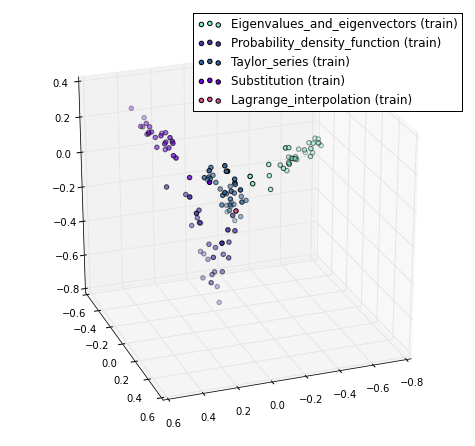

In [14]:
np.random.seed(23)
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .8, 1], elev=25, azim=70)

colors = [np.random.rand(3,1) for i in range(len(topic_tags))]

for i, l in zip(range(len(topic_tags)), train_labels):
    ax.scatter(pca_X_train[train_labels == i,0],
           pca_X_train[train_labels == i,1],
           pca_X_train[train_labels == i,2], c=colors[i], label = topic_tags[i] + ' (train)')
 
plt.legend()
plt.show()

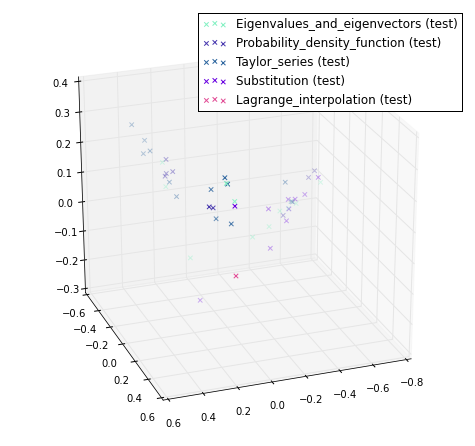

In [15]:
fig2 = plt.figure(1, figsize=(8, 6))
plt.clf()
ax2 = Axes3D(fig2, rect=[0, 0, .8, 1], elev=25, azim=70)
for i, l in zip(range(len(topic_tags)), test_labels):
    ax2.scatter(pca_X_train[test_labels == i,0],
           pca_X_train[test_labels == i,1],
           pca_X_train[test_labels == i,2], c=colors[i], label = topic_tags[i] + ' (test)', marker = 'x')   
 
plt.legend()
plt.show()

In [16]:
# this is moved to helpers
def predict_topic_for_question(q, classifier):
    vec = helpers.question_to_X(q)
    pred_prob = classifier.predict_proba(vec)
    pred_class = helpers.pred_to_topic(pred_prob, topic_tags)
    
    return pred_class

def determine_topic_for_question(q, classifier):
    # assumes only one topic
    if q == None:
        return None
    try:
        for t in topic_tags:
            if t in q['topics']:
                return t
    except KeyError:
        pass
    predicted = predict_topic_for_question(q, classifier)
    return predicted

In [17]:
# Predicting using the entire dataset:

X = helpers.questions_to_X(questions_raw)
y = helpers.questions_to_y(questions_raw, topic_tags)

final_classifier = classifier.fit(X, y)

#!!!
pickle.dump(final_classifier, open("test_sending_json/final.bin", "wb"))

In [18]:
print(helpers.determine_topic_for_question(questions_raw[77], trained_classifier, topic_tags).replace("_", " "))
print(questions_raw[77]['topics'])



client = MongoClient()
random_question = client['merdb'].questions.find_one()

print(helpers.determine_topic_for_question(random_question, final_classifier, topic_tags))
print(random_question.keys())
print(random_question['statement_html'])

Probability density function
[u'Expected_value_and_median', u'Probability_density_function']
Lagrange_interpolation
[u'rating', u'contributors', u'answer_html', u'course', u'year', u'sols_raw', u'hints_html', u'question', u'statement_raw', u'num_votes', u'statement_html', u'term', u'statement_latex', u'hints_raw', u'hints_latex', u'ID', u'sols_latex', u'url', u'flags', u'answer_latex', u'sols_html', u'_id']
<p>Suppose you are given a set of <em>N</em> data points <em>(x<sub>n</sub>, y<sub>n</sub>)</em>, with <em>x<sub>n</sub></em> increasing, and you wish to interpolate these points with a spline function <em><span class="math">\(f\)</span></em>, where <em><span class="math">\(f\)</span>(x)</em> is given by the cubic polynomial <em>p<sub>n</sub>(x)</em> on each interval <em>(x<sub>n</sub>, x<sub>n+1</sub>)</em> for <em>n = 1, ..., N-1</em>:</p>
<p><span class="math">\[\begin{aligned}
\displaystyle
p_n(x) = a_n(x-x_n)^3 + b_n(x-x_n)^2 + c_n(x-x_n) + d_n\end{aligned}\]</span></p>
<p><str